In [49]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture 
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score, classification_report, accuracy_score, confusion_matrix

## Pre-processing phase
1. **Load Dataframe**
Loads the dataset with network packets analyzed with Tshark and Tstat from a CSV file and stores the data in the df dataframe.

In [78]:
df = pd.read_csv('dataset.csv')

2. **Dataset normalization/standardization and modification**
Standardize the dataset using the StandardScaler from scikit-learn. The 'browser', 'website', and 'behaviour' columns are dropped before standardization because their type is string and cannot be computed by the scaler. Additionally, columns containing only zeros are removed.

In [51]:
#dataset standardization
scaler= StandardScaler()
df_without_labels = df.copy().drop(columns=['browser', 'website', 'behaviour'])
norm_dataset = scaler.fit_transform(df_without_labels)
norm_dataset = pd.DataFrame(norm_dataset, columns = df_without_labels.columns)
zero_columns = norm_dataset.columns[norm_dataset.eq(0).all()]
norm_dataset.drop(zero_columns, axis=1, inplace=True)


3. **Label Encoding**
LabelEncoder is used to encode the labels of the 'type' column, which is obtained by concatenating the 'browser' and 'website' columns. This creates an array of numeric labels called true_label. The commented lines are the different combinations of the labels, made for test and experiment phase.

In [77]:
# label encoding
label_encoder = LabelEncoder()
df['type'] = df['browser'] + '-' + df['website'] 
#df['type'] = df['browser'] + '-' + df['website'] + '-' + df['behaviour'] #try
#df['type'] = df['browser'] + '-' + df['behaviour'] #try
#df['type'] = df['website'] + '-' + df['behaviour'] #try
#df['type'] = df['browser'] #try
#df['type'] = df['website'] #try
#df['type'] = df['behaviour'] #try
true_label = label_encoder.fit_transform(df["type"]) 

4. **Compute the correlation matrix**
The correlation matrix between the features of the standardized dataset is calculated and displayed.

5. **Visualization of the Correlation Matrix via Heatmap**
A heatmap of the correlation matrix is created using the Seaborn library.

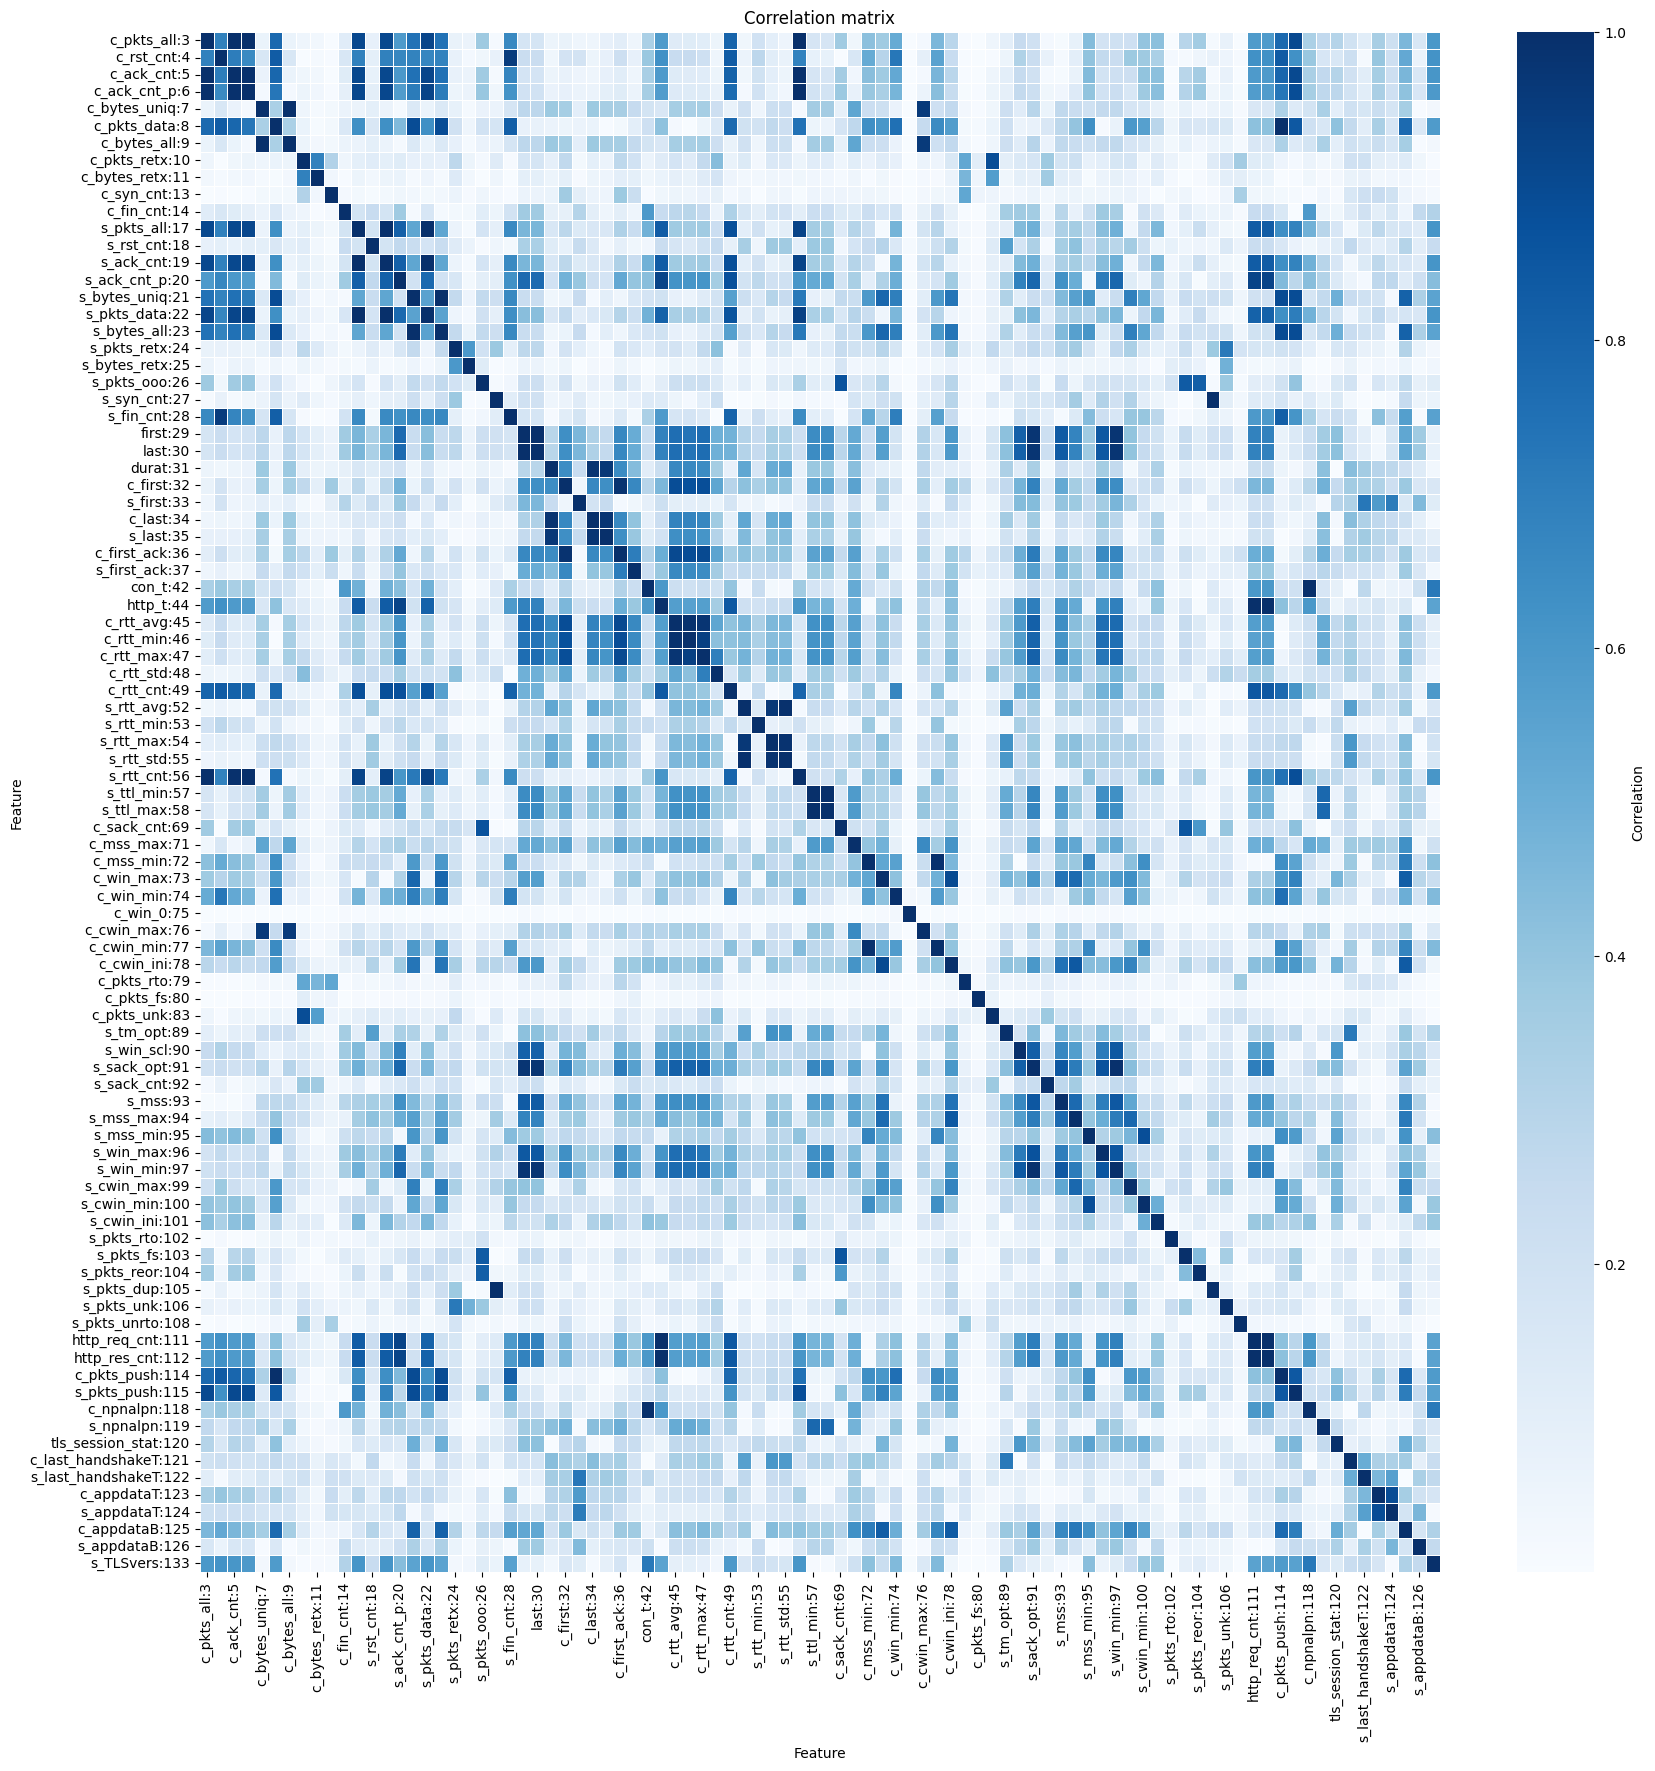

In [53]:
# Compute the correlation matrix
correlation_matrix = norm_dataset.corr().abs()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cmap='Blues', annot=False, cbar_kws={'label':'Correlation'}, linewidths=.5)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

6. **Correlation matrix using Spearman**
This additional code calculates the correlation matrix using the Spearman correlation coefficient.

7. **Visualizing the Spearman Correlation Matrix via Heatmap**
A heatmap of the Spearman correlation matrix is created using the Seaborn library, and it's similar to the previous visualization with Pearson correlation.

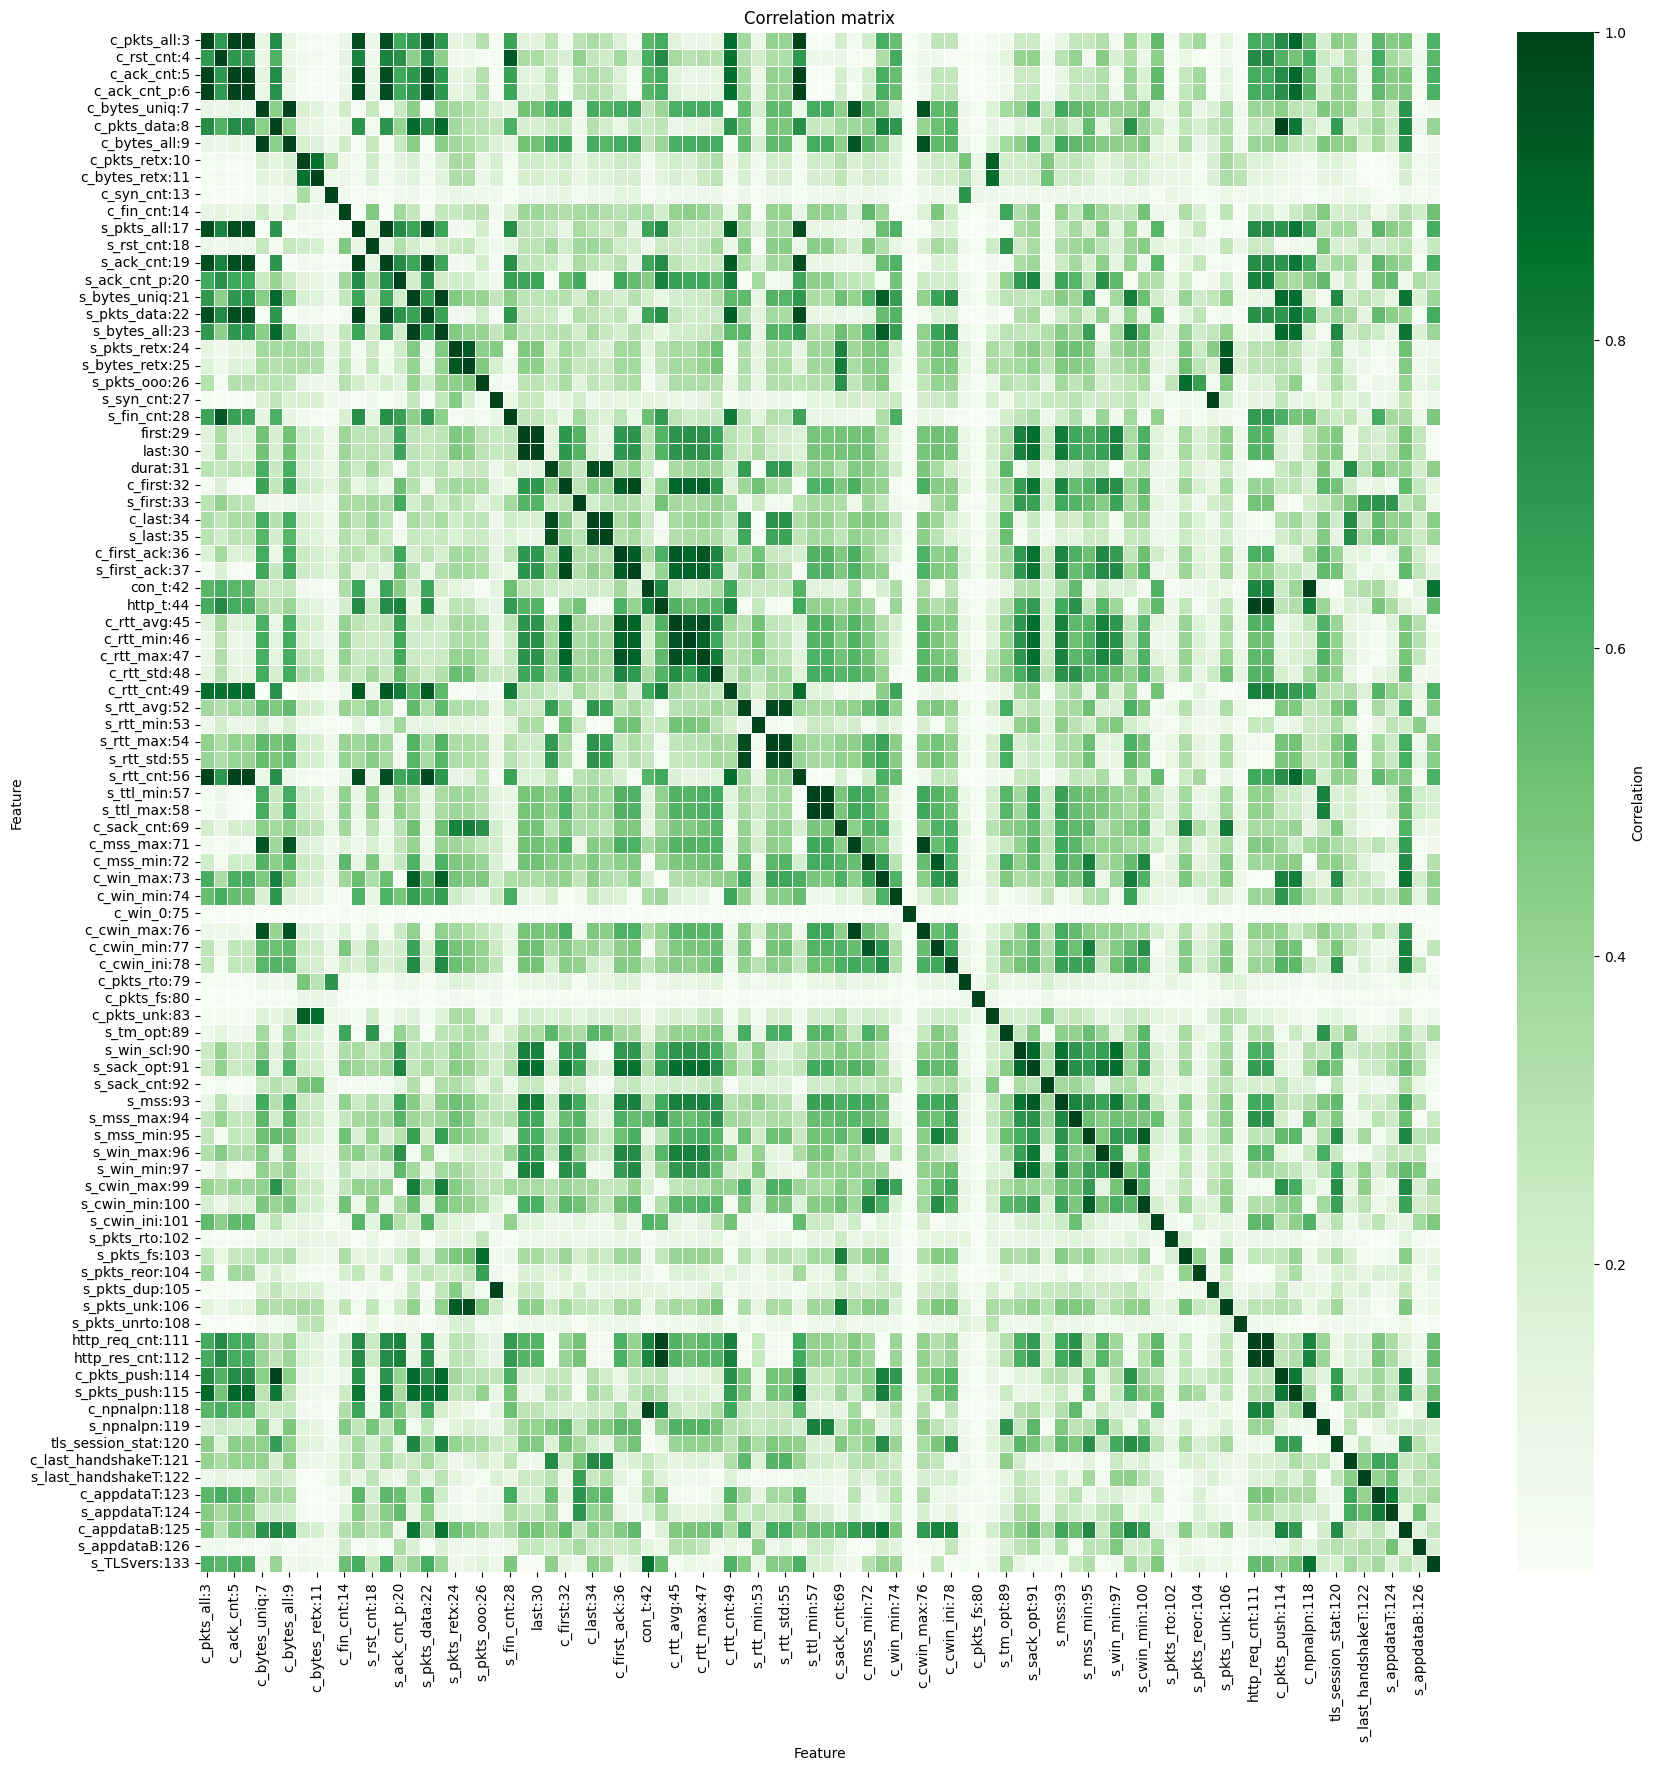

In [54]:
correlation_matrix_spearman = norm_dataset.corr(method='spearman').abs()

# Compute the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix_spearman, cmap='Greens', annot=False,  cbar_kws={'label':'Correlation'}, linewidths=.5)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

# UNSUPERVISED LEARNING
## 1 Dimensionality reduction
This phase is used to performs Kernel PCA and PCA on the normalized dataset to minimize the number of components and simplify the data, removing the noise and improving the computational efficiency.

1. **PCA**
A PCA object is initialized with a random state to initialize and transform it.

In [64]:
pca = PCA(random_state=15)

pca.fit(norm_dataset)

PCA(random_state=15)

2. **Cumulative explained variance**
The cumulative explained variance of the transformed data is computed from the transformed data obtained after the initial PCA.
Then the cumulative explained variance to a percentage by multiplying by 100. This can be useful to understand how much variance is retained when considering a specific number of principal components.

In [65]:
explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100

3. **Data Visualization**
A plot is created to visualize the cumulative explained variance and identify the number of components.

Observing the plot, it can be noted that the optimal compromise is achieved by selecting 21 components, which allow obtaining 90% of the cumulative explained variance.

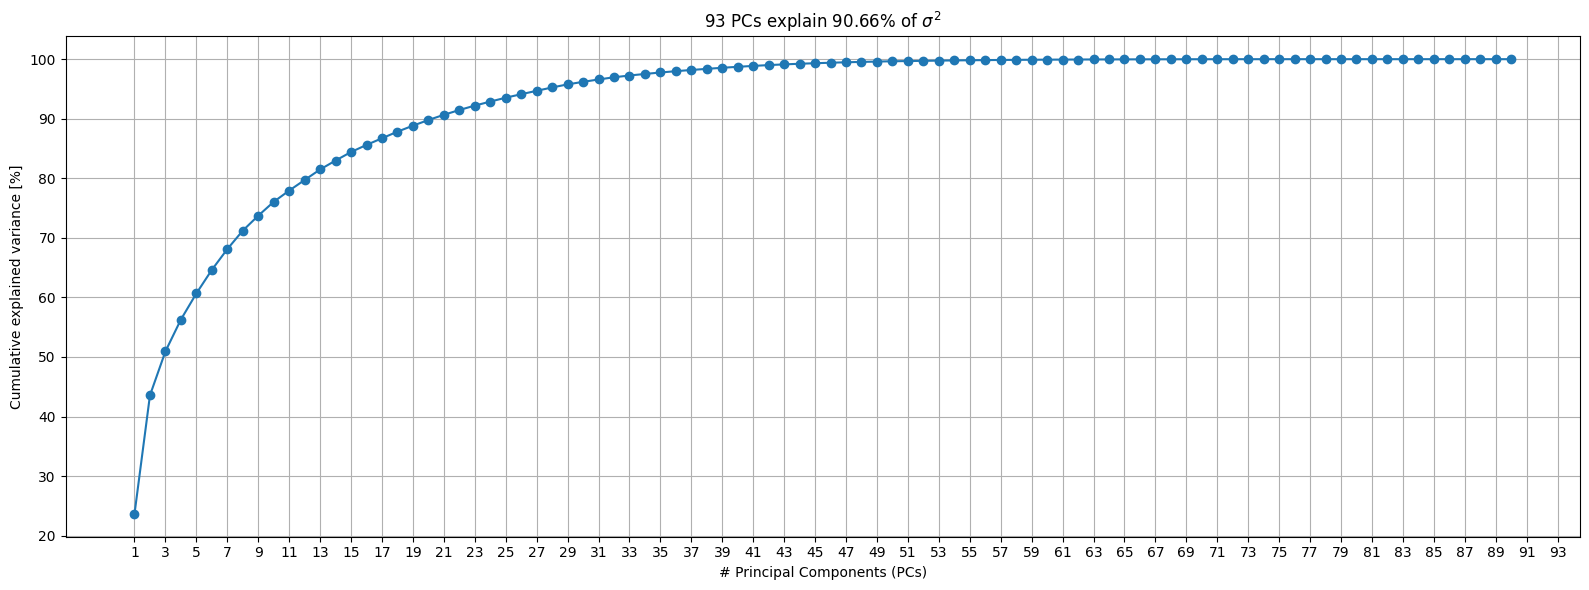

In [66]:
plt.figure(figsize=(16, 6))
plt.plot(perc_cumul_exp_var, marker='o', markersize=6)
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks(np.arange(0, 94, 2), np.arange(1, 94, 2))
plt.grid()
plt.title(f'93 PCs explain {round(perc_cumul_exp_var[20], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

4. **Dataset transformation**
PCA is reapplied with 21 components, the percentage of cumulative explained variance is calculated, and finally, the dataset is transformed


In [67]:
number_of_components=21

pca = PCA(n_components=number_of_components, random_state=10)
pca.fit(norm_dataset)
explained_variance = pca.explained_variance_ratio_ 
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100
print(perc_cumul_exp_var[-1])

pca_result = pca.transform(norm_dataset)
pca_result = pd.DataFrame(pca_result, columns=[f'PC{i}' for i in range(number_of_components)])


90.65554829808936


5. **Correlation matrix**
The correlation matrix of the dataset on which PCA has been applied is computed.
...

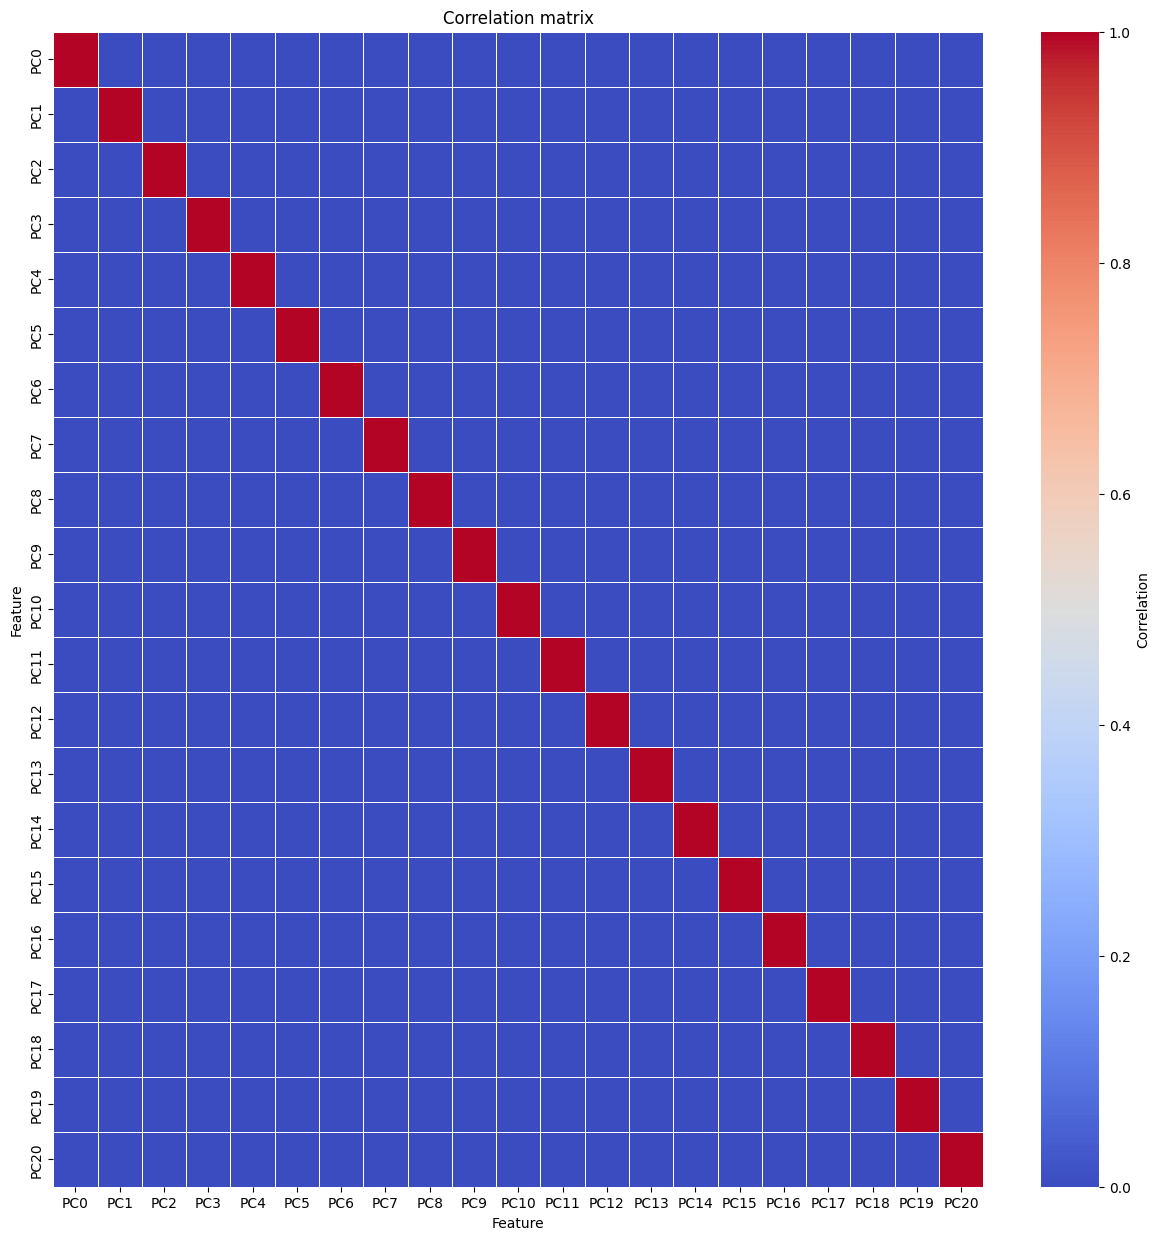

In [11]:
correlation_matrix = pca_result.corr().abs()

plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar_kws={'label':'Correlation'},linewidths=.5)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

6. **Loading score**
Finally, we performed an additional PCA analysis calculating the loading scores of features for each component. The results were visualized in a horizontal bar graph, showing the most significant loadings for the first five components

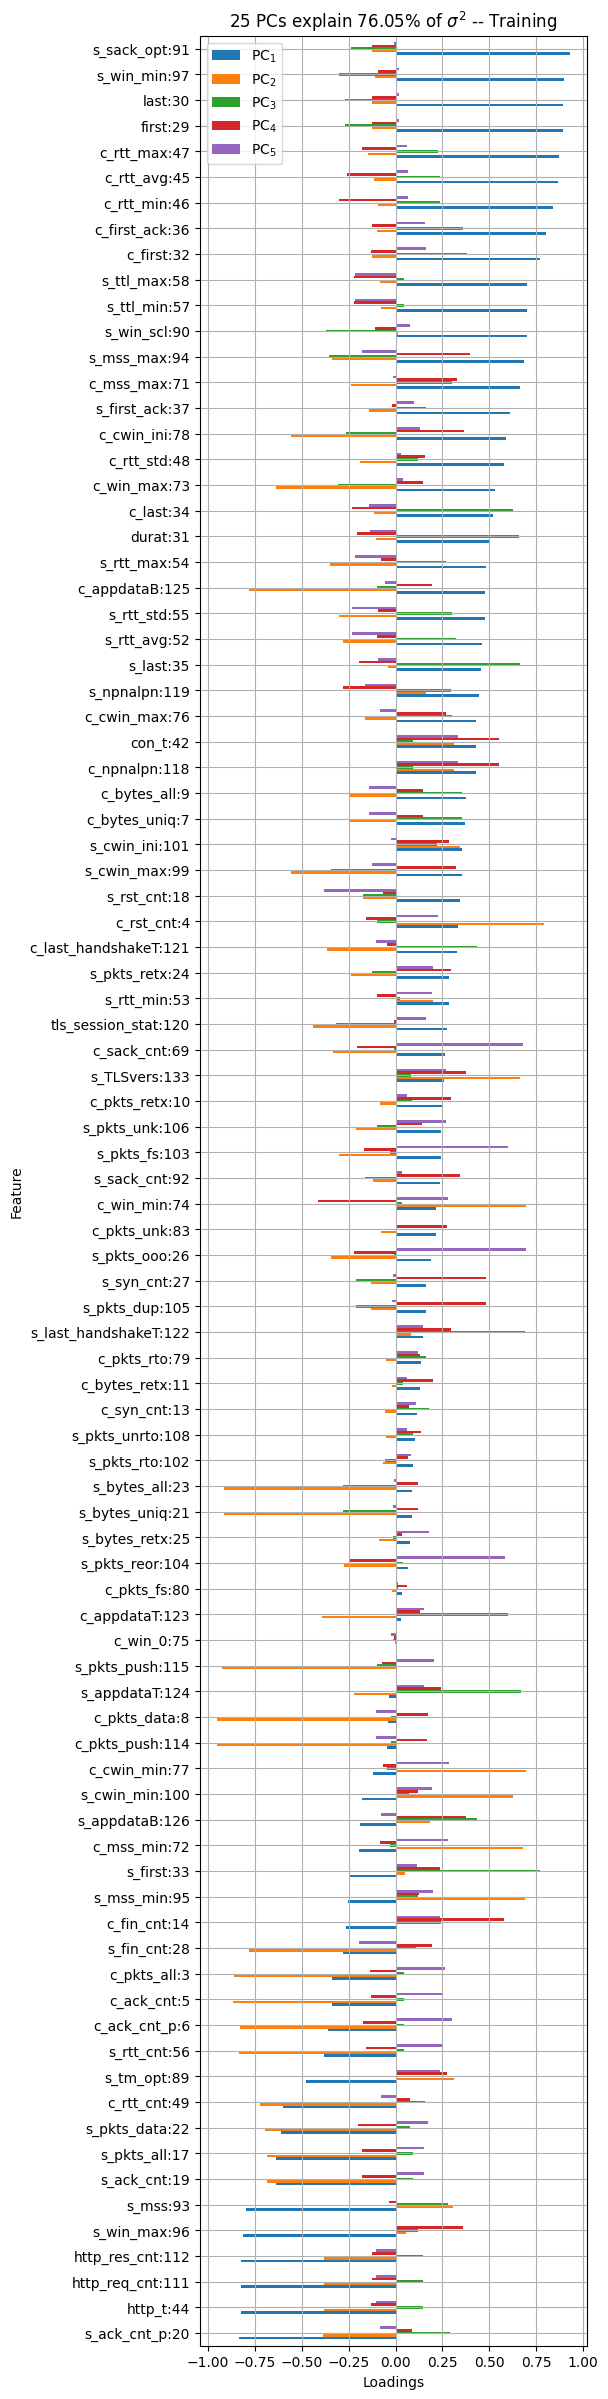

In [12]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, number_of_components+1)],
    index = norm_dataset.columns
)

plt.figure(figsize=(5,30))
loadings = loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
loadings.sort_values(['PC1', 'PC2']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$', 'PC3':'PC$_{3}$', 'PC4':'PC$_{4}$', 'PC5':'PC$_{5}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'25 PCs explain {round(perc_cumul_exp_var[9], 2)}% of $\sigma^2$ -- Training')
plt.show()

7. **KPCA**
A list named reconstruction_errors is initialized to store the reconstruction error for each tested number of KPCA components, and a loop is executed over a range of KPCA components, from 10 to 19.
For each iteration, a new dataset with n_components is created using KernelPCA. Subsequently, the transformed dataset is reconstructed to obtain an approximate representation of the original dataset. The mean squared error between the original and reconstructed datasets is then calculated. The error is added to the reconstruction_errors list

In [13]:
from sklearn.metrics import mean_squared_error

reconstruction_errors = []

for n_components in range(10,19):
    kpca = KernelPCA(n_components=n_components, kernel='cosine', gamma=10,  fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(norm_dataset)
    X_reconstructed = kpca.inverse_transform(X_kpca)
    error = mean_squared_error(norm_dataset, X_reconstructed)
    reconstruction_errors.append(error)

8. **Plot**
A graph is created to display the reconstruction error as it varies with the number of tested KPCA components. Then, the number of components is chosen as 12, representing a balanced tradeoff between the number of components used and the reconstruction error of the original dataset

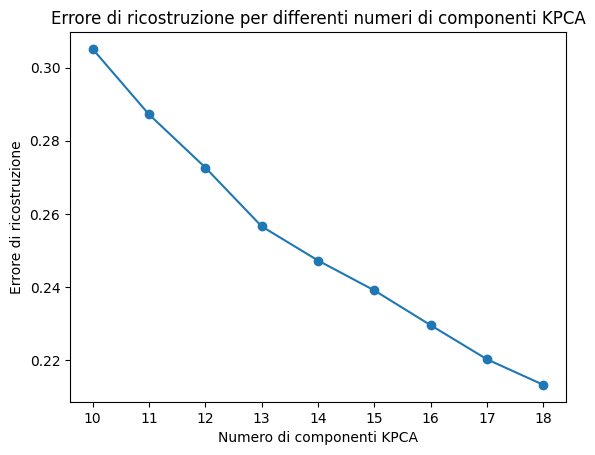

In [14]:
plt.plot(range(10,19), reconstruction_errors, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error for different number of components KPCA')
plt.show()

9. **Dataset transformation**
The normalized dataset is transformed using Kernel Principal Component Analysis (KPCA), and the result is stored in kpca_result.

In [16]:
kpca = KernelPCA(kernel='cosine', gamma=13, n_components=13)
kpca_result = kpca.fit_transform(norm_dataset)
kpca_result = pd.DataFrame(kpca_result, columns=[f'PC{i}' for i in range(13)])

10. **Original Datset,PCA, KPCA**
The figure shows three subplots: the first represents the original data, the second shows the data after applying KPCA, and the third represents the data after using PCA

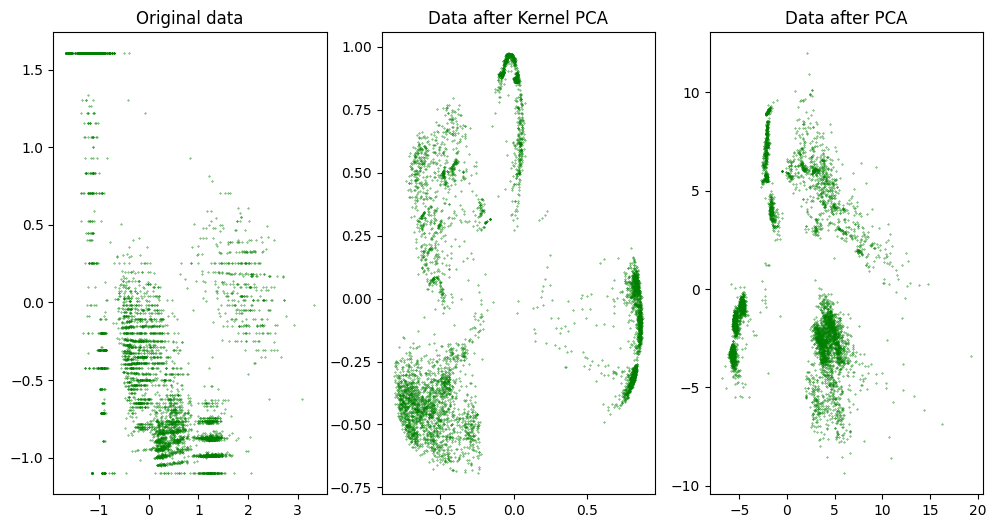

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(norm_dataset.iloc[:, 0], norm_dataset.iloc[:, 1], s=0.1, c= "green")
plt.title('Original data')

plt.subplot(1, 3, 2)
plt.scatter(kpca_result.iloc[:, 0], kpca_result.iloc[:, 1], s = 0.1, c = "green")
plt.title('Data after Kernel PCA')

plt.subplot(1, 3, 3)
plt.scatter(pca_result.iloc[:, 0], pca_result.iloc[:, 1], s = 0.1, c = "green")
plt.title('Data after PCA')

plt.show()

## 2 Clustering

1. **Purity-score**
This purity_score function takes two arrays of labels, y_true and y_pred, as arguments and calculates the "purity" of the clustering. Purity is an evaluation metric for the quality of a clustering, measuring how much instances in each cluster are consistent with a single class.

In [69]:
dataset = pca_result

def purity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
    return purity

2. **Clustering function**
Creating an help function to plot the KPCA results with the calculated clusters to show the precision of the cluster discovered previously.
It is possible to change the pca components plotted by modifying the values of the X.iloc[: x], X.iloc[: y]. X and y are the components that would be choose in the plot. 

In [19]:
def plot_clustering(X, labels, centers=None, title="", subplot=None):

    if subplot:
        plt.subplot(subplot)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=labels) 

    if centers is not None:
        plt.scatter(
            centers[:, 0], centers[:, 1], c="red", s=150, alpha=0.9, label="Centers"
        )

    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

    plt.figure(figsize=(10, 8))

3. **Find the best number of clusters**
Iterate over a range of cluster numbers, creates KMeans models with random initialization, fits each model to PCA-transformed data, and stores the results in the kmeans_results list. The purpose of running this loop is likely to explore how the quality of clustering changes with different numbers of clusters.

4. **Visualize the trend on different clusters**
Visualize the clustering error and silhouette scores as functions of the number of clusters. The first plot helps identify the optimal number of clusters based on the "elbow" in the curve (where the rate of decrease in inertia slows down), while the second plot uses silhouette scores to evaluate the quality of the clustering for different cluster numbers.

5. **Calculation of Silhouette Score**
The Silhouette Score is computed and printed, indicating how well-separated the clusters are. This metric provides insight into the cohesion and separation of clusters.

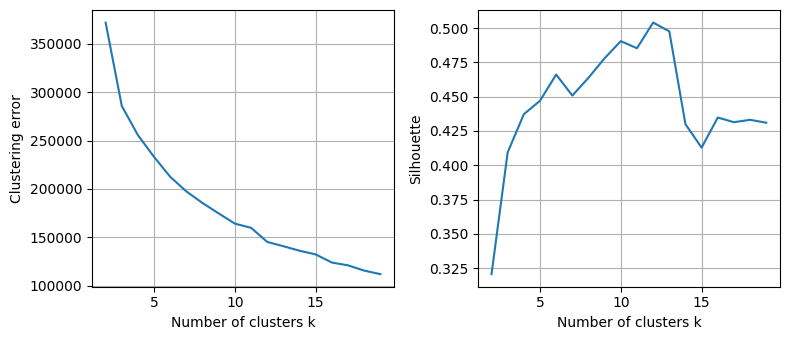

In [22]:
kmeans_results = []
for k in range(2,20): #60
    kmeans_results.append(KMeans(n_clusters=k, init='random', random_state=6, n_init=100).fit(dataset)) 

fig, axs = plt.subplots(1,2, figsize=(8, 3.5))

axs[0].plot(
    [k for k in range(2,20)], 
    [result.inertia_ for result in kmeans_results]
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    [k for k in range(2,20)], 
    [silhouette_score(dataset, result.labels_) for result in kmeans_results]
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()


6. **KMeans**
A KMeans model is created with 12 clusters using random initialization, and a seed is set for reproducibility (random_state=6). The model is trained on dimension-reduced data obtained through KPCA (kpca_result).

Results for PCA for k= 12 and label= browser+website

RI between clustering and given classes is  0.9236960473273143
ARI between clustering and given classes is  0.5818525233731608
Silhouette Score: 0.4258849265485025
Purity for K-Means: 0.6024844720496895


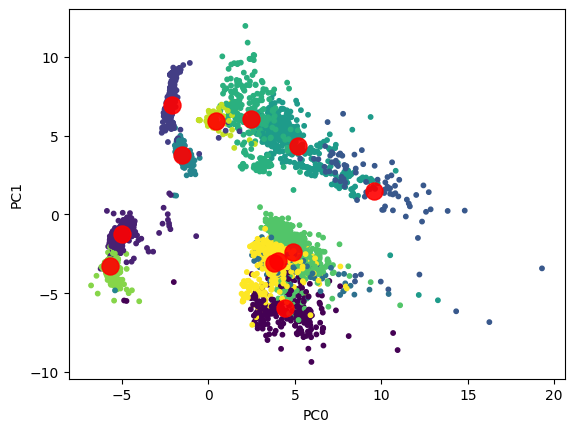

<Figure size 1000x800 with 0 Axes>

In [70]:
kmeans = KMeans(n_clusters=12, init='random', random_state=4, n_init=150) 
kmeans.fit(dataset)

print("Results for PCA for k= 12 and label= browser+website\n")

rand_score_result = rand_score(true_label, kmeans.labels_)
adj_rand_score_result = adjusted_rand_score(true_label,kmeans.labels_ )

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)
silhouette_avg = silhouette_score(dataset, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)
purity_kmeans = purity_score(true_label, kmeans.labels_)
print("Purity for K-Means:", purity_kmeans)


plot_clustering(dataset, kmeans.labels_, kmeans.cluster_centers_)

### Hyperparameter tuning for DBSCAN algorithm

1. **Setup of variables**
The first step is to create the variables and initialize them.
2. **Find the optimal hyperparameters**
Iterates over all combinations of eps and min_samples values and for each combination creates a DBSCAN object. The object is then fitted with the dataset, and calculates the silhouette score and the number of outliers. Return -1 if the value is not valid or it retunrs only 1 cluster.
3. **Visualization of the heatmaps**
One heatmap shows the silhouette scores and the other heatmap shows the number of outliers. These visualizations help in identifying the hyperparameter combinations that result in the best clustering performance.

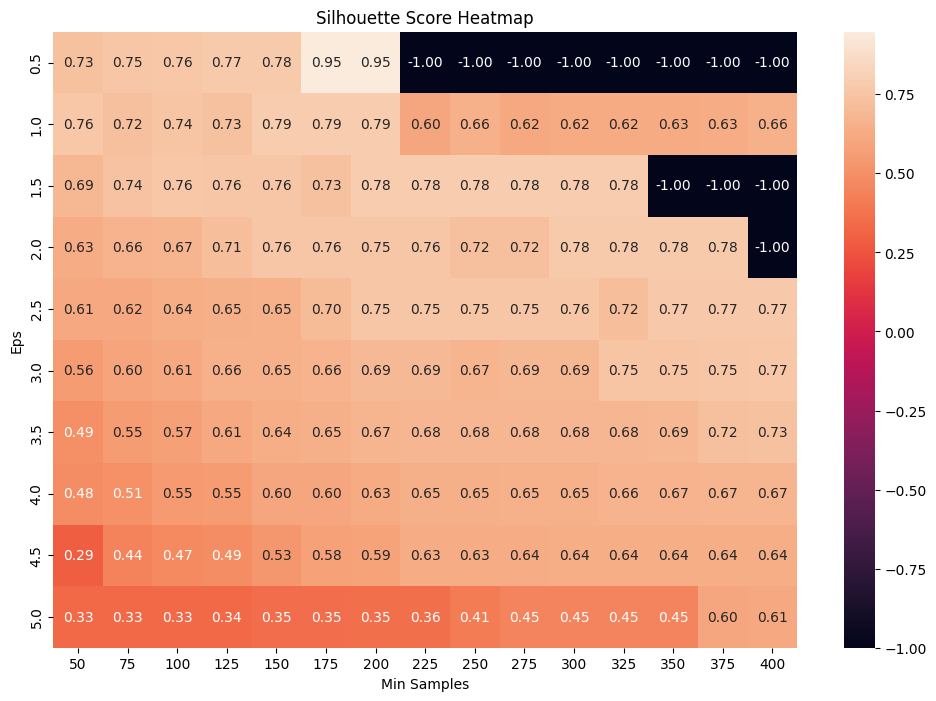

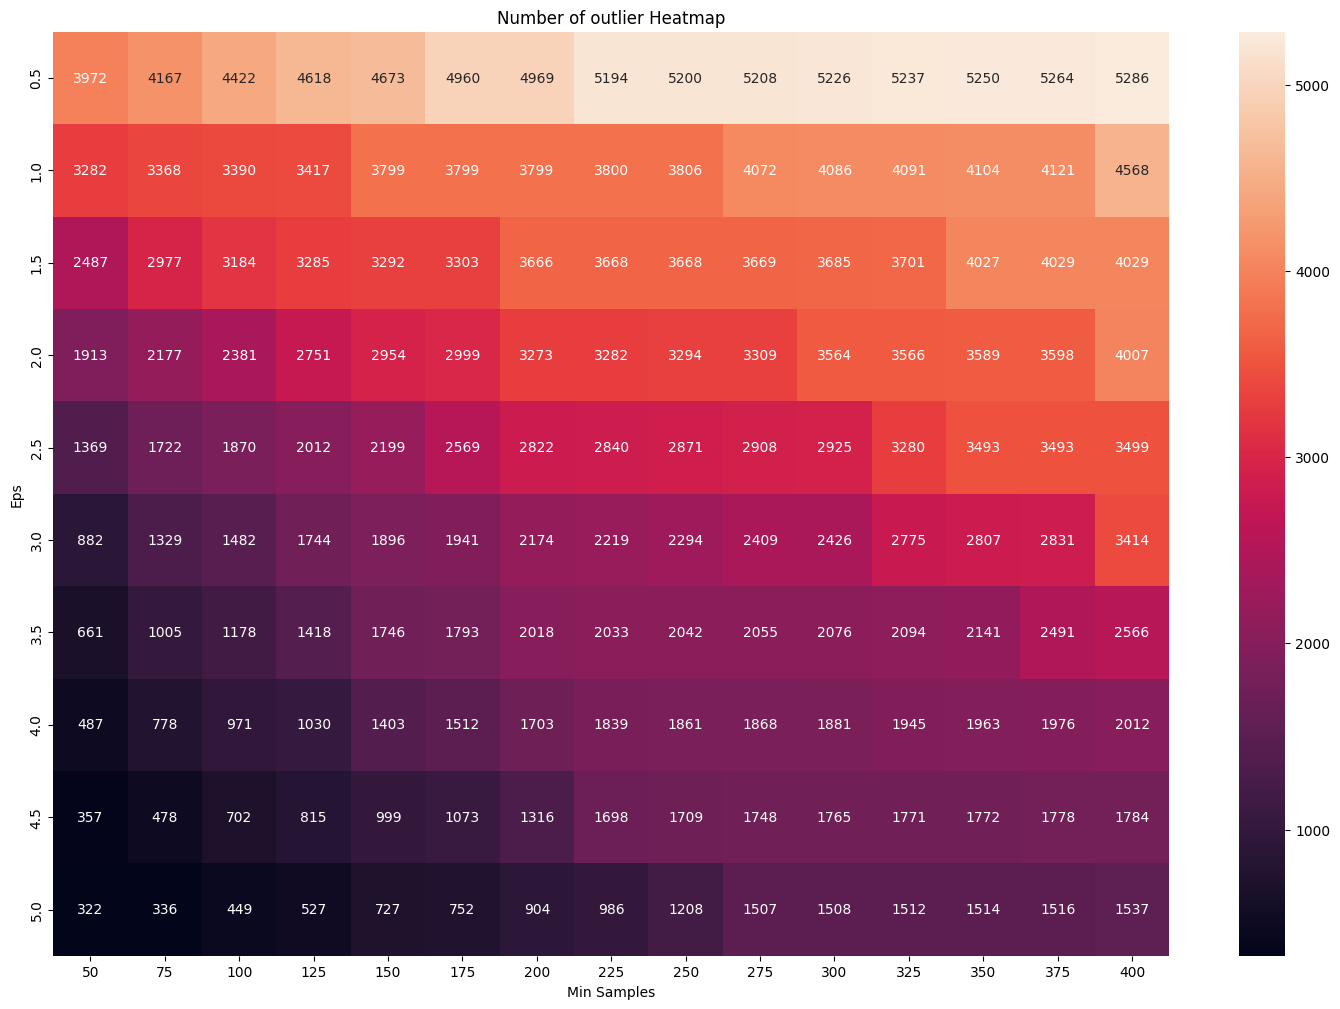

In [24]:
eps_values = np.arange(0.5, 5.5, 0.5)
min_samples_values = np.arange(50, 425, 25)

## HYPERPARAMETER TUNING
results = np.zeros((len(eps_values), len(min_samples_values)))
outliers_count = np.zeros_like(results)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(dataset)

        outliers_count[i, j] = np.sum(labels == -1)

        unique_labels = set(labels) - {-1} # Exclude the noise
        if len(unique_labels) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(dataset[labels != -1], labels[labels != -1])
            results[i, j] = score
        else:
            results[i, j] = -1

plt.figure(figsize=(12, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=min_samples_values, yticklabels=eps_values)
plt.title("Silhouette Score Heatmap")
plt.xlabel("Min Samples")
plt.ylabel("Eps")
plt.show()

plt.figure(figsize=(18, 12))
sns.heatmap(outliers_count, annot=True, fmt=".0f", xticklabels=min_samples_values, yticklabels=eps_values)
plt.title("Number of outlier Heatmap")
plt.xlabel("Min Samples")
plt.ylabel("Eps")
plt.show()

4. **Removing the outliers**
Filter the database without labels by removing the outliers, so when the value is equal to -1.

In [86]:
dbscan = DBSCAN(eps=3.5, min_samples=100) 

dbscan.fit(pca_result)

outliers_mask = dbscan.labels_ == -1

clean_data = pca_result[~outliers_mask]
display(clean_data)

clean_labels = true_label[~outliers_mask]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,2.877543,6.497631,-1.431468,-1.789592,-0.014905,-0.869493,0.897880,-1.754934,0.952952,0.110296,...,-0.203670,0.618179,3.320908,-0.259392,0.287710,0.118675,-0.145129,-0.557955,0.457944,-0.785959
2,3.961908,5.474890,-0.718541,-1.111217,-0.058909,-2.227695,1.579358,-1.604728,0.645928,-0.158539,...,0.722550,0.460128,-0.146507,-0.557012,-0.893602,0.054024,0.169597,-0.666078,-0.261740,-0.214178
3,3.068633,6.341968,-1.869108,-3.710094,-0.859270,-0.620594,1.399328,-2.778805,0.443043,0.308835,...,-0.396735,1.021531,2.796876,-1.018377,-0.437995,0.034802,0.015505,-0.248246,0.167748,-0.253320
4,3.590289,4.879214,-0.965166,-0.444075,-0.434924,-2.143951,1.322124,-1.625162,0.506522,-0.149567,...,0.720855,-0.035377,0.967814,0.134979,-0.359379,0.069882,0.014905,-1.004346,0.103368,-0.126491
5,2.742643,6.071158,-1.904561,-2.946008,-0.813832,-0.393098,0.960047,-2.381522,0.003488,0.194642,...,-0.339946,0.471242,2.580219,-0.370014,0.016418,0.071199,-0.063676,-0.464765,0.335952,-0.461114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,-4.857323,-0.814425,1.898713,0.550024,-0.887139,0.089578,-0.002150,-0.450978,-0.433596,0.047245,...,0.133687,-0.093970,0.707971,-0.163569,-0.656007,-0.029607,0.121220,-0.412851,-0.201637,0.130784
5953,-4.586939,-0.895465,1.821700,0.729656,-0.716433,-0.034907,-0.282849,-0.394808,-0.424718,-0.151804,...,0.077071,-0.106051,0.341071,-0.197362,-0.434241,-0.009866,0.067005,-0.261245,-0.140477,0.043729
5954,-4.436294,-0.893750,1.702396,0.430598,-1.059673,0.262916,-0.560214,-0.127315,-0.140732,0.059874,...,-0.091491,-0.085703,0.331680,-0.002193,-0.384565,-0.026698,0.096228,-0.271835,-0.195617,0.290777
5955,-4.433377,-0.778820,2.201522,0.925710,-0.543607,-0.090551,-0.377981,-0.456053,-0.611419,-0.292445,...,0.087554,-0.121436,0.446478,-0.373524,-0.392583,0.021188,0.030122,-0.185083,-0.090631,-0.116338


5. **Kmeans cluster analysis**
Performs a KMeans clustering analysis with varying numbers of clusters (k) and evaluates the results using three metrics: clustering error, silhouette score, and Adjusted Rand Index (ARI). This plot helps identify an optimal number of clusters based on these evaluations.

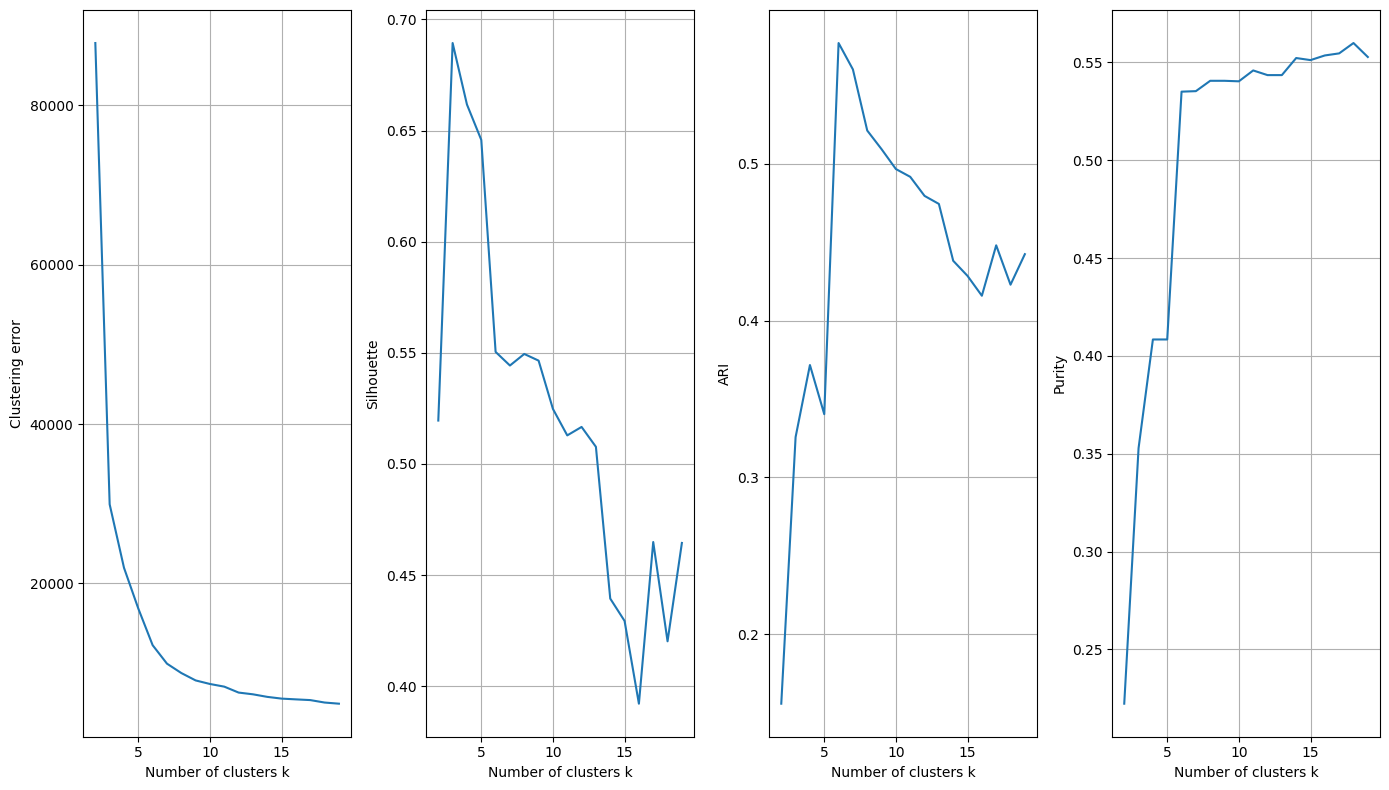

In [72]:
kmeans_results = []
for k in range(2, 20):
    kmeans_results.append(KMeans(n_clusters=k, init='random', random_state=4, n_init=100).fit(clean_data))

fig, axs = plt.subplots(1,4, figsize=(14, 8))

axs[0].plot(
    [k for k in range(2,20)], 
    [result.inertia_ for result in kmeans_results]
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    [k for k in range(2,20)], 
    [silhouette_score(clean_data, result.labels_) for result in kmeans_results]
)

axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

axs[2].plot(
    [k for k in range(2,20)], 
    [adjusted_rand_score(clean_labels,result.labels_ ) for result in kmeans_results]
)
axs[2].set_xlabel("Number of clusters k")
axs[2].set_ylabel("ARI")
axs[2].grid()

axs[3].plot(
    [k for k in range(2,20)], 
    [purity_score(clean_labels,result.labels_ ) for result in kmeans_results]
)
axs[3].set_xlabel("Number of clusters k")
axs[3].set_ylabel("Purity")
axs[3].grid()

plt.tight_layout()
plt.show()

6. **Set the "ideal" number of cluster**
After analyzing the previous results the number of clusters are now fixed on 12. Then some metrics are printed to show the result. 

The clustered labels are:
 [9 9 9 ... 4 4 4]

RI between clustering and given classes is  0.9171189077090183
ARI between clustering and given classes is  0.537435246424387
Silhouette Score: 0.5370534487941577
Purity for K-Means: 0.596777568528981


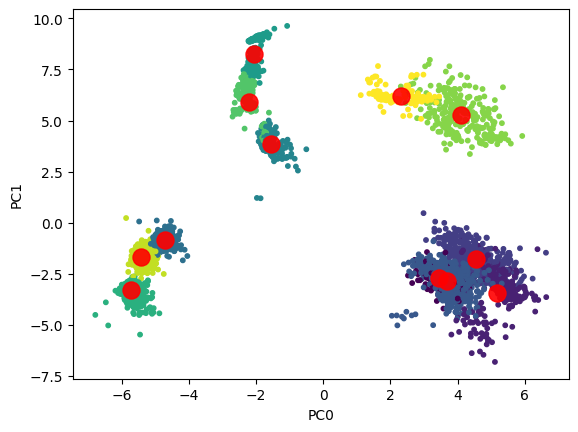

<Figure size 1000x800 with 0 Axes>

In [89]:
kmeans = KMeans(n_clusters=12, init='random', random_state=6, n_init=150)
kmeans.fit(clean_data)

print('The clustered labels are:\n', kmeans.labels_)
print()

rand_score_result = rand_score(clean_labels, kmeans.labels_)
adj_rand_score_result = adjusted_rand_score(clean_labels,kmeans.labels_ )

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)
silhouette_avg = silhouette_score(clean_data, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)
purity_kmeans = purity_score(clean_labels, kmeans.labels_)
print("Purity for K-Means:", purity_kmeans)


plot_clustering(clean_data, kmeans.labels_, kmeans.cluster_centers_)

# SUPERVISED LEARNING
## Decision tree

1. **Split the dataset**
The first step is splitting the dataset in training and validation.
2. **Create confusion matrix function**
A help function is created to print the confusion matrix. This function was used multiple times during the test phase to find the best output and values.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

true_label = pd.Series(true_label)
dataset = kpca_result

X_train, X_val, y_train, y_val = train_test_split(
    dataset, 
    true_label, 
    stratify = true_label, 
    train_size = 0.7, 
    random_state = 15
)

def confusion_matrix_(y_true, y_pred):
    df = pd.DataFrame(list(zip(y_true, y_pred)), columns=['y_true', 'y_pred'])
    df['samples'] = 1
    confusion = pd.pivot_table(df, index='y_true', columns='y_pred', values='samples', aggfunc='sum', fill_value=0)
    plt.figure()
    sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label': 'Occurrences'}, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

3. **Initialize the grid search**
First, specifies a dictionary of hyperparameter values to be tested, initializes a decision tree classifier with the entropy criterion and then sets up a grid search cross-validator. The validator uses accuracy as the scoring metric and returns the training scores. The grid search is parallelized with 4 jobs (n_jobs=4). Finally, the grid search is fitted with the dataset with corresponding true labels.

In [41]:
param_grid = {
    'max_depth' : [4,8,None],
    'min_samples_leaf': [1,3,5],
    'min_samples_split' : [2,4]
}

dt = DecisionTreeClassifier(criterion='entropy')
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', return_train_score=True,n_jobs=4)
grid_search.fit(dataset,true_label)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(criterion='entropy'),
             n_jobs=4,
             param_grid={'max_depth': [4, 8, None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4]},
             return_train_score=True, scoring='accuracy')

4. **Calculate scores** 
Extracts the mean test scores and parameter values for visualization and then calculates mean training scores.

In [42]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = [params['max_depth'] for params in grid_search.cv_results_['params']]

mean_train_scores = grid_search.cv_results_['mean_train_score']
mean_test_scores = grid_search.cv_results_['mean_test_score']

5. **Visualization of accuracies**
Creates a bar plot comparing mean training and validation accuracies for each parameter combination.

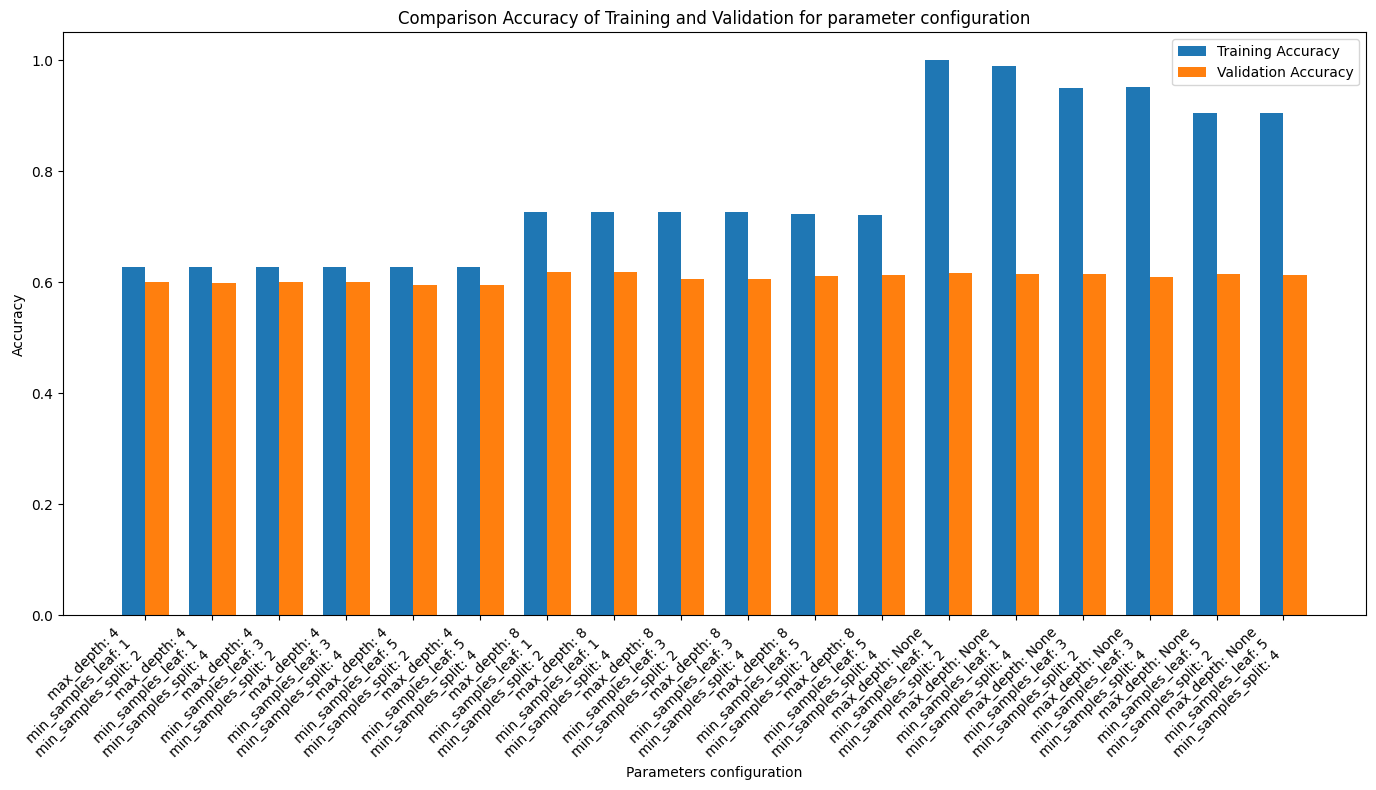

In [43]:
param_combinations = ['\n'.join([f"{k}: {v}" for k, v in params.items()]) for params in grid_search.cv_results_['params']]
n_combinations = len(param_combinations)

plt.figure(figsize=(14, 8))
ind = np.arange(n_combinations)
width = 0.35

plt.bar(ind - width/2, mean_train_scores, width, label='Training Accuracy')
plt.bar(ind + width/2, mean_test_scores, width, label='Validation Accuracy')

plt.xlabel('Parameters configuration')
plt.ylabel('Accuracy')
plt.title('Comparison Accuracy of Training and Validation for parameter configuration')
plt.xticks(ind, param_combinations, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

6. **Decision tree model**
This structure systematically evaluates the performance of a Decision Treen model on different portions of the training set and random states. It also collect statistics for both training and validation accuracies.

In [44]:
info_accuracy_train = []
info_accuracy_val = []

for train_size in np.arange(0.1, 1, 0.1):

    random_states = set()
    while len(random_states) < 10:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    for random_state in random_states:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
        index_selected = list(sss.split(X_train, y_train))[0][0]
        X_train_selected = X_train.iloc[index_selected]
        y_train_selected = y_train.iloc[index_selected]
        
        dt_tmp = DecisionTreeClassifier(criterion = "entropy", 
                    max_depth = 8, 
                    min_samples_split = 4,
                    random_state = None)
        dt_tmp.fit(X_train_selected, y_train_selected)
        accuraries_train_tmp.append(accuracy_score(y_train_selected, dt_tmp.predict(X_train_selected)))
        accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val)))

    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))

7. **Plot the Learning Curve**
Create a learning curve for the decision tree classifier with the data collected with the Decision Tree model.

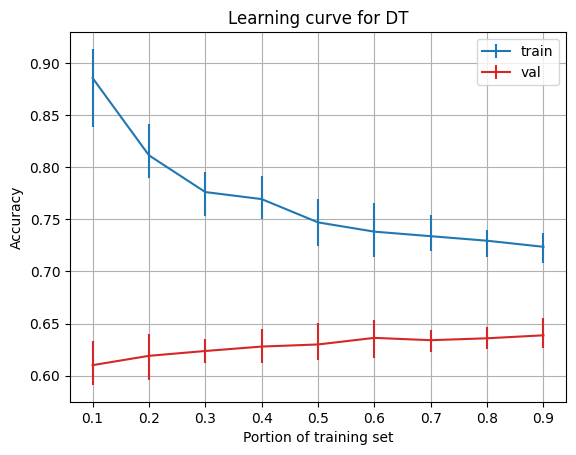

In [45]:
plt.figure()
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)],
    [info[0] for info in info_accuracy_train], 
    
    yerr=[
        [info[0]-info[1] for info in info_accuracy_train], 
        [info[2]-info[0] for info in info_accuracy_train]
    ], 
    color='tab:blue', label='train'
)
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], 
    [info[0] for info in info_accuracy_val], 
    
    yerr=[
        [info[0]-info[1] for info in info_accuracy_val], 
        [info[2]-info[0] for info in info_accuracy_val]
    ], 
    color='tab:red', label='val'
)
plt.grid()
plt.xlabel('Portion of training set')
plt.ylabel('Accuracy')
plt.title('Learning curve for DT')
plt.legend()
plt.show()

8. **Training of the Decision Treen Model**
Splits the pca dataset in validation and training sets. Then, initializes a Decision Tree classifier with a given random state (in this case, None) and trains it on the training set created previously. Finally, calculates the accuracy of the model on both training and validation set, printing all the metrics and labels.

0.7228577595510468
0.648036253776435
1567     3
4788     9
5079    10
870      1
1393     2
        ..
1430     2
4656     9
1789     3
4286     8
2800     5
Length: 1324, dtype: int32
[3 9 6 ... 2 4 9]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       107
           1       0.98      0.93      0.95       109
           2       0.77      0.90      0.83       111
           3       0.89      0.72      0.80       109
           4       0.51      0.84      0.63       111
           5       0.59      0.41      0.48       111
           6       0.53      0.55      0.54       111
           7       0.52      0.66      0.58       111
           8       0.58      0.19      0.29       111
           9       0.54      0.73      0.62       111
          10       0.52      0.49      0.50       111
          11       0.52      0.40      0.45       111

    accuracy                           0.65      1324
   macro avg   

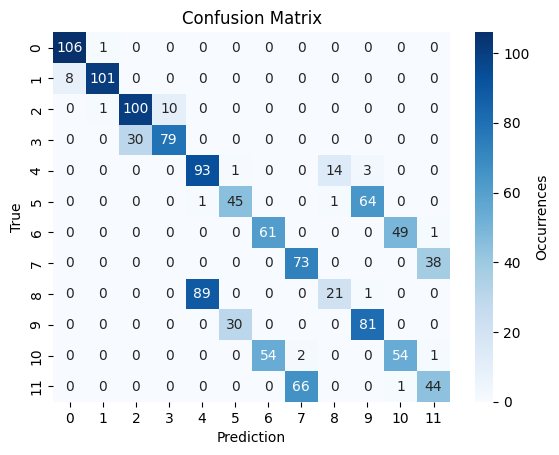

In [46]:
dataset = kpca_result

X_train, X_val, y_train, y_val = train_test_split(
    dataset, 
    true_label, 
    stratify = true_label, 
    train_size = 0.7/0.9, 
    random_state = 15
)


dt = DecisionTreeClassifier(criterion = "entropy", 
                    max_depth = 8, 
                    min_samples_split = 4,
                    random_state = None)
dt.fit(X_train, y_train)
accuraries_train = accuracy_score(y_train, dt.predict(X_train))
accuraries_val = accuracy_score(y_val, dt.predict(X_val))

print(accuraries_train)
print(accuraries_val)

print(y_val)
print(dt.predict(X_val))

print("\nClassification Report:")
print(classification_report(y_val, dt.predict(X_val)))

print("\nMatrice di Confusione:")
confusion_matrix_(y_val, dt.predict(X_val))



9. **Select the best number of neighobours k**
We calculate the validation curve to estimate which k is the best for a selected combination of true_labels.

Validation Means: [0.6347167514749886, 0.6259862841557768, 0.6049986193994106, 0.6006340901278605, 0.5863695276091943, 0.5828425157360291, 0.5895551930305029]
Validation Maxs: [0.6448362720403022, 0.6372795969773299, 0.6375838926174496, 0.6280436607892528, 0.6171284634760705, 0.6053736356003359, 0.6171284634760705]
Validation Mins: [0.6272040302267002, 0.6036943744752309, 0.563392107472712, 0.5583543240973972, 0.5499580184718724, 0.5474391267842149, 0.5348446683459278]


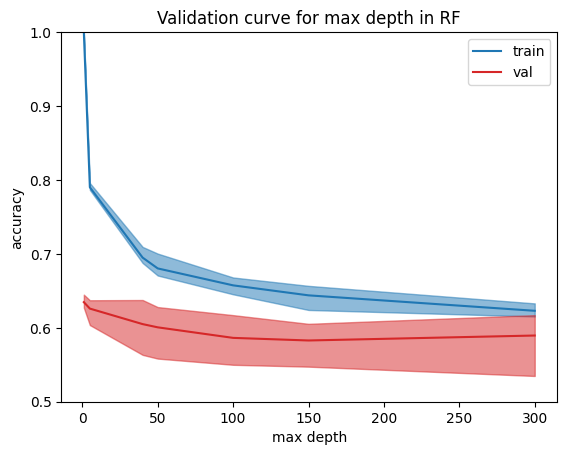

1


In [47]:
from sklearn.neighbors import KNeighborsClassifier

acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

array = [1,5,40,50,100,150,300]

for n in array:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_validate(knn, dataset, true_label, cv=5, scoring='accuracy', return_train_score=True)
    acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())


print("Validation Means:", acc_val_means)
print("Validation Maxs:", acc_val_maxs)
print("Validation Mins:", acc_val_mins)

plt.figure()
x = array
plt.plot(x, acc_train_means, color='tab:blue', label='train')
plt.fill_between(x, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(x, acc_val_means, color='tab:red', label='val')
plt.fill_between(x, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend()
plt.title("Validation curve for max depth in RF")
plt.ylim(0.5,1)
plt.show()

n = np.argmax(acc_val_means)
n = array[n]

10. **Performs the prediction**
We assess the results of the prediction with the previous selected hyprparameter k.

Accuracy Train: 1.0
Accuracy Validation: 0.6450151057401813


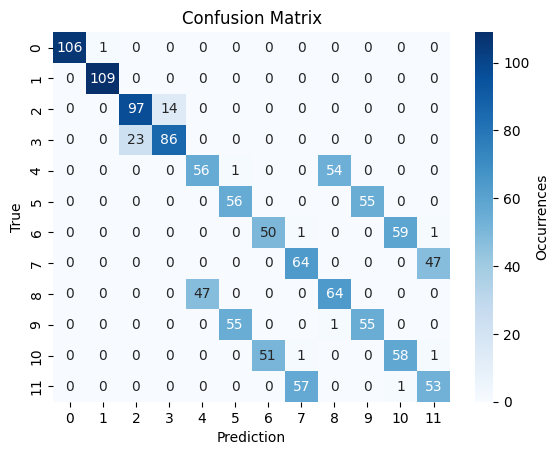

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    dataset, 
    true_label, 
    stratify = true_label, 
    train_size = 0.7/0.9, 
    random_state = 15
)

knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train, y_train)

accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_val = accuracy_score(y_val, knn.predict(X_val))
print("Accuracy Train:", accuracy_train)
print("Accuracy Validation:", accuracy_val)
confusion_matrix_(y_val, knn.predict(X_val))